In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy import stats
#!pip install catboost
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
import catboost

In [2]:
train = pd.read_csv(r"C:\Users\piyus\Desktop\Kaggle\train.csv")
test  = pd.read_csv(r"C:\Users\piyus\Desktop\Kaggle\test.csv")

In [3]:
print(f"Train Shape : {train.shape}")
print(f"Test  Shape : {test.shape}")

Train Shape : (1460, 81)
Test  Shape : (1459, 80)


In [4]:
#These functions are solely created for Initial Data Analysis by my self to get help for all the Inital Data Analysis
def cat_columns(dataset,thshold=4):
    """
       This will take Dataset name as the input and return a list of columns 
       from the same Dataset which are Categorical
       
       Note: There might be a few mismatches.
       
    """ 
    l = dataset.columns
    list_vcount_count = []
    for col in l:
        list_vcount_count.append(dataset[col].value_counts().count())
    list_vcount_count.sort()    
    for threshhold in range(len(list_vcount_count)):
        diff = list_vcount_count[threshhold+1] - list_vcount_count[threshhold]
        if diff > list_vcount_count[threshhold]:
            break 
    #threshhold Value is intact
    categorical_columns = []
    for col in l:
        if dataset[col].value_counts().count() <= threshhold:
            categorical_columns.append(col)
        elif dataset[col].value_counts().count() > 0 and dataset[col].value_counts().count() <= thshold:
            categorical_columns.append(col)
    return categorical_columns
def summarize_data(data):
    print(f"Head :\n{data.head()}")
    print(40*"*")
    print(f"Shape:\n{data.shape}")
    print(40*"*")
    print(f"All about Exp-Salaries :\n{data.describe()}")
    print(40*"*")
    print(f"Columnns :\n{data.columns}")
    print(40*"*")
    for i in cat_columns(data):
        print(f"Value counts for {i}\n{data[i].value_counts()}")
        print(10*("-"))
    print(40*"*")
    print(f"Checking if there are any null values :\n{data.isna().any()}") # If Null values present fill them/take care of them!

In [5]:
summarize_data(train)

Head :
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008      

In [6]:
train.rename(columns={'1stFlrSF': 'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThreeSsnPorch'}, inplace=True)
test.rename(columns={'1stFlrSF': 'FirstFlrSF','2ndFlrSF':'SecondFlrSF','3SsnPorch':'ThreeSsnPorch'}, inplace=True)

In [7]:
list_categorical_cols = cat_columns(train)
print(list_categorical_cols)
print(f"Number of Possible Categorical Columns : {len(list_categorical_cols)}")

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'ThreeSsnPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Number of Possible Categorical Columns : 61


### 1. Features which are not Categorical to check 
    LowQualFinSF(Not CAT),
    BsmtFullBath(Cat),
    BsmtHalfBath(Cat),
    FullBath(Cat),
    HalfBath(Cat),
    3SsnPorch(Not CAT),
    PoolArea(Not CAT)
#### Removing the Non CAT features from the categorical Features list


### 2. Misc Feature Check for the Below Features
    Bedroom- should it be Categorical?     
#####                Yes
    Kithen - Should Kitchen be Categorical 
#####                Yes
    BedroomAbvGr- What is this in the Dataset 
#####                This is nothing but Bedroom Above Grade Documentation has it written as bedroom and is Categorical
    KitchenAbvGr- What is this in the Dataset 
#####                This is nothing but Kitchen Above Grade Documentation has it written as Kitchen and is Categorical

In [8]:
list_categorical_cols.remove('LowQualFinSF')
list_categorical_cols.remove('ThreeSsnPorch')
list_categorical_cols.remove('PoolArea')
print(f"Number of Possible Categorical Columns : {len(list_categorical_cols)}")

Number of Possible Categorical Columns : 58


In [9]:
len(list_categorical_cols)

58

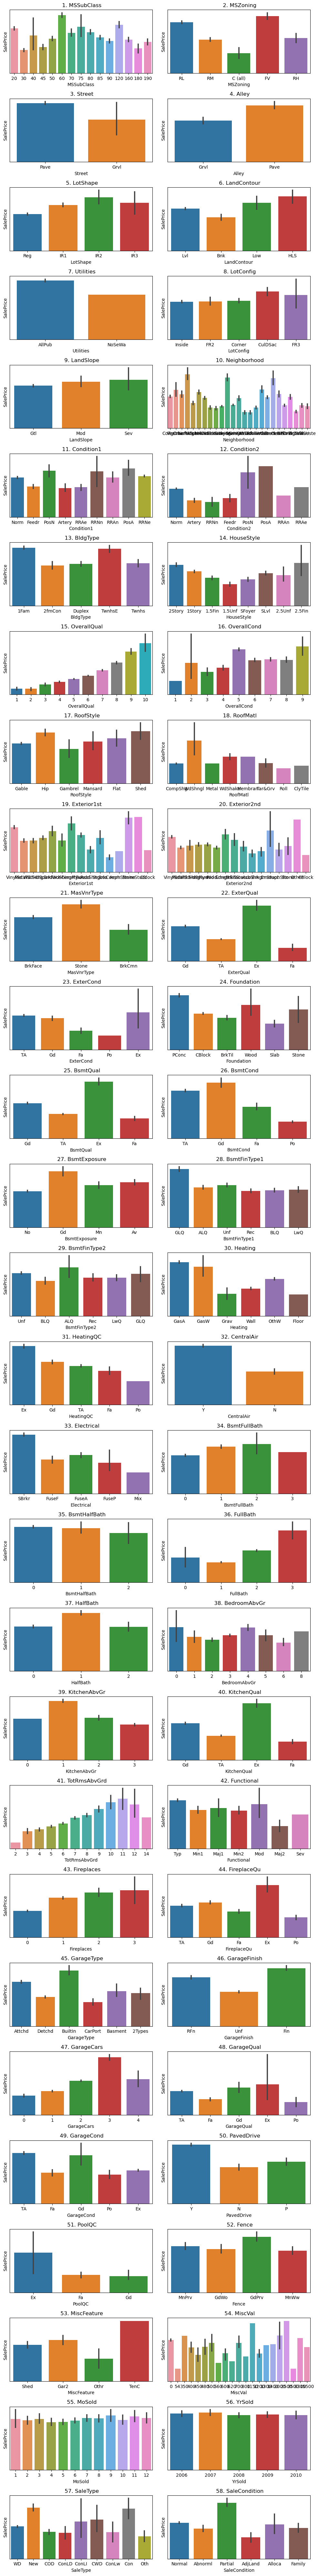

In [10]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(29, 2, figsize=(10, 80))
axs = axs.flatten()
for i in range(len(list_categorical_cols)):
    sns.barplot(data=train, x=list_categorical_cols[i], y='SalePrice', ax=axs[i])
    axs[i].set_title(f' {i+1}. {list_categorical_cols[i]}')
    axs[i].tick_params(axis='y', left=False, labelleft=False) # Turn off y-axis ticks and tick labels
    axs[i].tick_params(axis='x', bottom=True, labelbottom=True) # Turn on x-axis ticks and tick labels
plt.tight_layout()
plt.show()


In [11]:
list_non_categorical_cols = [col for col in train.columns if col not in list_categorical_cols]
print(list_non_categorical_cols)
print(len(list_non_categorical_cols))

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ThreeSsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice']
23


In [12]:
list_non_categorical_cols

['Id',
 'LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'FirstFlrSF',
 'SecondFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 'ThreeSsnPorch',
 'ScreenPorch',
 'PoolArea',
 'SalePrice']

### Numerical Columns | Feature Selection | Checking Correlation Coefficicents 

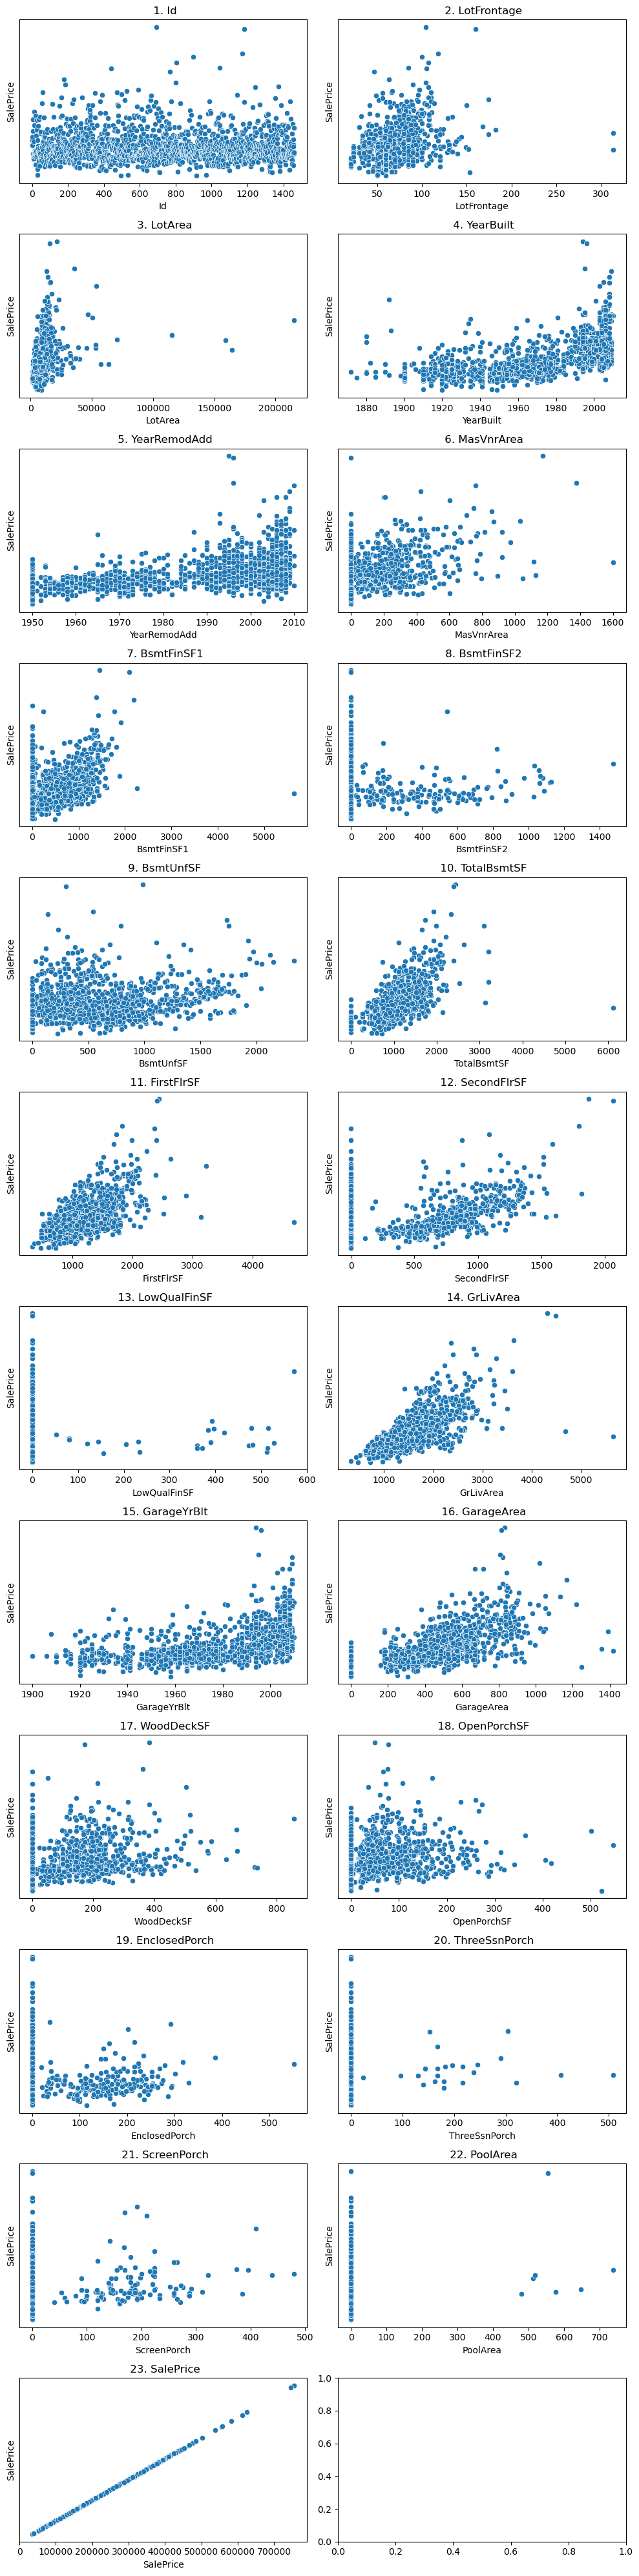

In [13]:
fig, axs = plt.subplots(12, 2, figsize=(10, 40))
axs = axs.flatten()
for i in range(len(list_non_categorical_cols)):
    sns.scatterplot(data=train, x=list_non_categorical_cols[i], y='SalePrice', ax=axs[i])
    axs[i].set_title(f' {i+1}. {list_non_categorical_cols[i]}')
    axs[i].tick_params(axis='y', left=False, labelleft=False) # Turn off y-axis ticks and tick labels
    axs[i].tick_params(axis='x', bottom=True, labelbottom=True) # Turn on x-axis ticks and tick labels
plt.tight_layout()
plt.show()

In [14]:
# Heatmap
# Try and reduce the features which are correlated perfectly 
#- Check for number of any type of room and area of the same type of room

In [15]:
numerical_train = train[list_non_categorical_cols]
numerical_train

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ThreeSsnPorch,ScreenPorch,PoolArea,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,...,1710,2003.0,548,0,61,0,0,0,0,208500
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,...,1262,1976.0,460,298,0,0,0,0,0,181500
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,...,1786,2001.0,608,0,42,0,0,0,0,223500
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,...,1717,1998.0,642,0,35,272,0,0,0,140000
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,...,2198,2000.0,836,192,84,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,1999,2000,0.0,0,0,953,953,...,1647,1999.0,460,0,40,0,0,0,0,175000
1456,1457,85.0,13175,1978,1988,119.0,790,163,589,1542,...,2073,1978.0,500,349,0,0,0,0,0,210000
1457,1458,66.0,9042,1941,2006,0.0,275,0,877,1152,...,2340,1941.0,252,0,60,0,0,0,0,266500
1458,1459,68.0,9717,1950,1996,0.0,49,1029,0,1078,...,1078,1950.0,240,366,0,112,0,0,0,142125


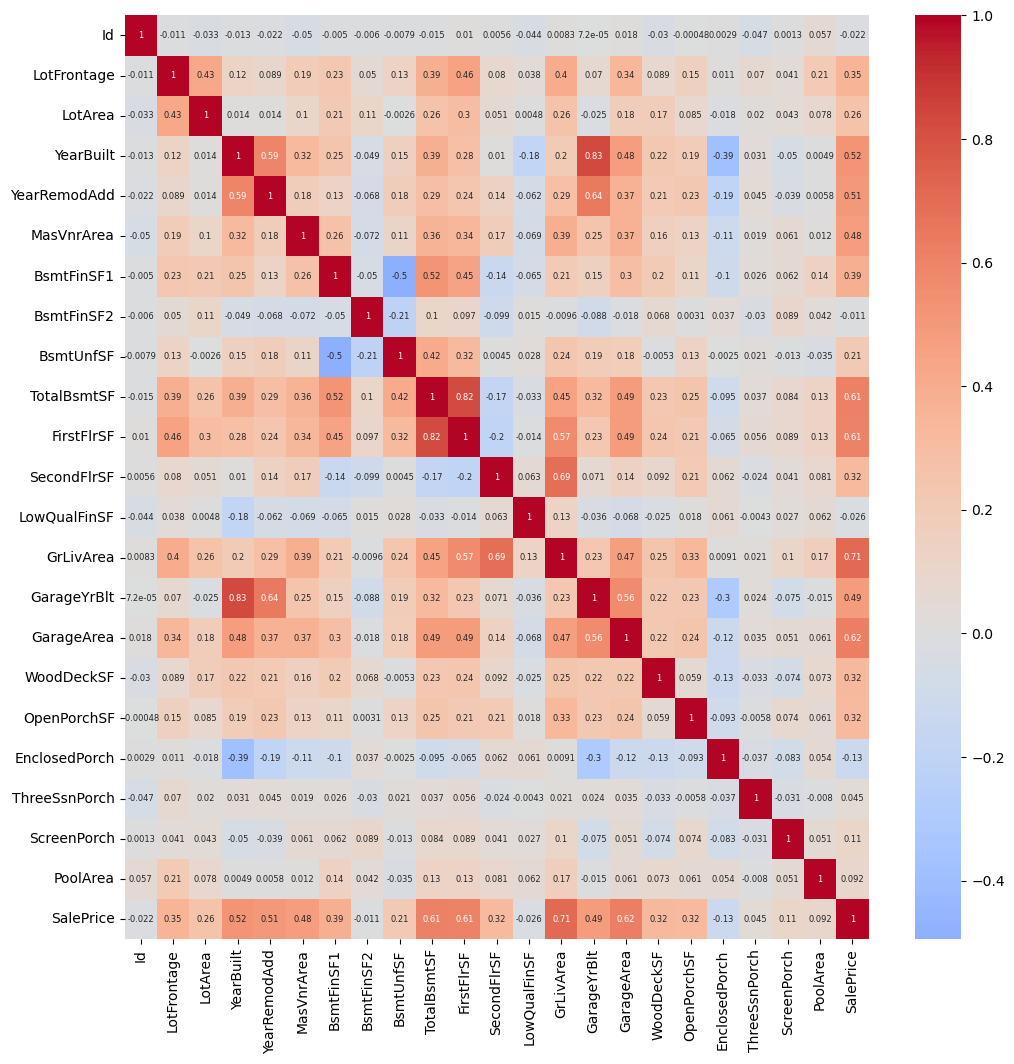

In [16]:
correlation_matrix = numerical_train.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,annot_kws={"size": 6})

plt.show()

##### We are creating a list of columns to be reomoved and will keep on appending this list as and when we get columns which may add on to the multicollinearity

## We are maintaining this list - list_non_categorical_cols, where in if we need to remove any column, it should be appended here first

In [17]:
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if  correlation_matrix.iloc[i,j] <= -0.7 or correlation_matrix.iloc[i,j] >= 0.7 :
            if correlation_matrix.columns[i] != correlation_matrix.columns[j]:
                print(f" {correlation_matrix.columns[i]} {correlation_matrix.columns[j]} -> {round(correlation_matrix.iloc[i,j],3)}")
#We will remove the columns GarageYrBlt and 1stFlrSF
columns_to_be_removed = ['GarageYrBlt','1stFlrSF']

 YearBuilt GarageYrBlt -> 0.826
 TotalBsmtSF FirstFlrSF -> 0.82
 FirstFlrSF TotalBsmtSF -> 0.82
 GrLivArea SalePrice -> 0.709
 GarageYrBlt YearBuilt -> 0.826
 SalePrice GrLivArea -> 0.709


In [18]:
list_non_categorical_cols.remove('Id') # Id does not contribute

In [19]:
#Hypothesis Formulation
# H0 : Null Hypothesis        :  Not dependent 
# H1 : Alternate Hypothesis   :   dependent
col_num_relation = {}
for numeric_column in list_non_categorical_cols:
    cnt = 0
    for cat_column in list_categorical_cols:
        formula = f"{numeric_column} ~ C({cat_column})"
        a = ols(formula, data = train).fit()
        table = anova_lm(a,typ =2)
        if table.iloc[0,3] <= 0.05:
            print(f"{numeric_column} is related to {cat_column}")
            cnt = cnt + 1
        else:
            print(f"{numeric_column} is NOT RELATED to {cat_column}")
    col_num_relation[numeric_column] = cnt
print()
print(col_num_relation)

LotFrontage is related to MSSubClass
LotFrontage is related to MSZoning
LotFrontage is NOT RELATED to Street
LotFrontage is related to Alley
LotFrontage is related to LotShape
LotFrontage is related to LandContour
LotFrontage is NOT RELATED to Utilities
LotFrontage is related to LotConfig
LotFrontage is related to LandSlope
LotFrontage is related to Neighborhood
LotFrontage is related to Condition1
LotFrontage is NOT RELATED to Condition2
LotFrontage is related to BldgType
LotFrontage is related to HouseStyle
LotFrontage is related to OverallQual
LotFrontage is related to OverallCond
LotFrontage is related to RoofStyle
LotFrontage is related to RoofMatl


C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


LotFrontage is related to Exterior1st
LotFrontage is related to Exterior2nd
LotFrontage is NOT RELATED to MasVnrType
LotFrontage is related to ExterQual
LotFrontage is NOT RELATED to ExterCond
LotFrontage is related to Foundation
LotFrontage is related to BsmtQual
LotFrontage is NOT RELATED to BsmtCond
LotFrontage is related to BsmtExposure
LotFrontage is related to BsmtFinType1
LotFrontage is NOT RELATED to BsmtFinType2
LotFrontage is related to Heating
LotFrontage is related to HeatingQC
LotFrontage is related to CentralAir
LotFrontage is NOT RELATED to Electrical
LotFrontage is related to BsmtFullBath
LotFrontage is NOT RELATED to BsmtHalfBath
LotFrontage is related to FullBath
LotFrontage is NOT RELATED to HalfBath
LotFrontage is related to BedroomAbvGr
LotFrontage is NOT RELATED to KitchenAbvGr
LotFrontage is related to KitchenQual
LotFrontage is related to TotRmsAbvGrd
LotFrontage is NOT RELATED to Functional
LotFrontage is related to Fireplaces
LotFrontage is NOT RELATED to Fire

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 17
  warnings.warn('covariance of constraints does not have full '


LotArea is related to Alley
LotArea is related to LotShape
LotArea is related to LandContour
LotArea is NOT RELATED to Utilities
LotArea is related to LotConfig
LotArea is related to LandSlope
LotArea is related to Neighborhood
LotArea is NOT RELATED to Condition1
LotArea is NOT RELATED to Condition2
LotArea is related to BldgType
LotArea is NOT RELATED to HouseStyle
LotArea is related to OverallQual
LotArea is NOT RELATED to OverallCond
LotArea is related to RoofStyle
LotArea is related to RoofMatl
LotArea is related to Exterior1st
LotArea is related to Exterior2nd
LotArea is related to MasVnrType
LotArea is related to ExterQual
LotArea is NOT RELATED to ExterCond
LotArea is NOT RELATED to Foundation
LotArea is related to BsmtQual
LotArea is NOT RELATED to BsmtCond
LotArea is related to BsmtExposure
LotArea is NOT RELATED to BsmtFinType1
LotArea is related to BsmtFinType2
LotArea is related to Heating
LotArea is NOT RELATED to HeatingQC
LotArea is NOT RELATED to CentralAir
LotArea is 

BsmtFinSF1 is related to MSSubClass
BsmtFinSF1 is related to MSZoning
BsmtFinSF1 is NOT RELATED to Street
BsmtFinSF1 is NOT RELATED to Alley
BsmtFinSF1 is related to LotShape
BsmtFinSF1 is related to LandContour
BsmtFinSF1 is NOT RELATED to Utilities
BsmtFinSF1 is related to LotConfig
BsmtFinSF1 is related to LandSlope
BsmtFinSF1 is related to Neighborhood
BsmtFinSF1 is related to Condition1
BsmtFinSF1 is related to Condition2
BsmtFinSF1 is NOT RELATED to BldgType
BsmtFinSF1 is related to HouseStyle
BsmtFinSF1 is related to OverallQual
BsmtFinSF1 is related to OverallCond
BsmtFinSF1 is related to RoofStyle
BsmtFinSF1 is related to RoofMatl
BsmtFinSF1 is related to Exterior1st
BsmtFinSF1 is related to Exterior2nd
BsmtFinSF1 is related to MasVnrType
BsmtFinSF1 is related to ExterQual
BsmtFinSF1 is related to ExterCond
BsmtFinSF1 is related to Foundation
BsmtFinSF1 is related to BsmtQual
BsmtFinSF1 is related to BsmtCond
BsmtFinSF1 is related to BsmtExposure
BsmtFinSF1 is related to BsmtF

FirstFlrSF is related to Neighborhood
FirstFlrSF is related to Condition1
FirstFlrSF is related to Condition2
FirstFlrSF is related to BldgType
FirstFlrSF is related to HouseStyle
FirstFlrSF is related to OverallQual
FirstFlrSF is related to OverallCond
FirstFlrSF is related to RoofStyle
FirstFlrSF is related to RoofMatl
FirstFlrSF is related to Exterior1st
FirstFlrSF is related to Exterior2nd
FirstFlrSF is related to MasVnrType
FirstFlrSF is related to ExterQual
FirstFlrSF is NOT RELATED to ExterCond
FirstFlrSF is related to Foundation
FirstFlrSF is related to BsmtQual
FirstFlrSF is NOT RELATED to BsmtCond
FirstFlrSF is related to BsmtExposure
FirstFlrSF is related to BsmtFinType1
FirstFlrSF is NOT RELATED to BsmtFinType2
FirstFlrSF is NOT RELATED to Heating
FirstFlrSF is related to HeatingQC
FirstFlrSF is related to CentralAir
FirstFlrSF is related to Electrical
FirstFlrSF is related to BsmtFullBath
FirstFlrSF is NOT RELATED to BsmtHalfBath
FirstFlrSF is related to FullBath
FirstFlrS

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '


LowQualFinSF is related to BsmtCond
LowQualFinSF is NOT RELATED to BsmtExposure
LowQualFinSF is related to BsmtFinType1
LowQualFinSF is NOT RELATED to BsmtFinType2
LowQualFinSF is NOT RELATED to Heating
LowQualFinSF is NOT RELATED to HeatingQC
LowQualFinSF is NOT RELATED to CentralAir
LowQualFinSF is NOT RELATED to Electrical
LowQualFinSF is NOT RELATED to BsmtFullBath
LowQualFinSF is NOT RELATED to BsmtHalfBath
LowQualFinSF is NOT RELATED to FullBath
LowQualFinSF is NOT RELATED to HalfBath
LowQualFinSF is related to BedroomAbvGr
LowQualFinSF is NOT RELATED to KitchenAbvGr
LowQualFinSF is related to KitchenQual
LowQualFinSF is related to TotRmsAbvGrd
LowQualFinSF is related to Functional
LowQualFinSF is NOT RELATED to Fireplaces
LowQualFinSF is NOT RELATED to FireplaceQu
LowQualFinSF is related to GarageType
LowQualFinSF is related to GarageFinish
LowQualFinSF is related to GarageCars
LowQualFinSF is related to GarageQual
LowQualFinSF is related to GarageCond
LowQualFinSF is related to

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full 

GarageYrBlt is related to Exterior1st
GarageYrBlt is related to Exterior2nd
GarageYrBlt is related to MasVnrType
GarageYrBlt is related to ExterQual
GarageYrBlt is related to ExterCond
GarageYrBlt is related to Foundation
GarageYrBlt is related to BsmtQual
GarageYrBlt is related to BsmtCond
GarageYrBlt is related to BsmtExposure
GarageYrBlt is related to BsmtFinType1
GarageYrBlt is related to BsmtFinType2
GarageYrBlt is related to Heating
GarageYrBlt is related to HeatingQC
GarageYrBlt is related to CentralAir
GarageYrBlt is related to Electrical
GarageYrBlt is related to BsmtFullBath
GarageYrBlt is related to BsmtHalfBath
GarageYrBlt is related to FullBath
GarageYrBlt is related to HalfBath
GarageYrBlt is related to BedroomAbvGr
GarageYrBlt is NOT RELATED to KitchenAbvGr
GarageYrBlt is related to KitchenQual
GarageYrBlt is related to TotRmsAbvGrd
GarageYrBlt is related to Functional
GarageYrBlt is related to Fireplaces
GarageYrBlt is related to FireplaceQu
GarageYrBlt is related to Ga

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 10
  warnings.warn('covariance of constraints does not have full '
C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 19
  warnings.warn('covariance of constraints does not have full '


GarageArea is related to MSZoning
GarageArea is NOT RELATED to Street
GarageArea is NOT RELATED to Alley
GarageArea is related to LotShape
GarageArea is related to LandContour
GarageArea is NOT RELATED to Utilities
GarageArea is related to LotConfig
GarageArea is NOT RELATED to LandSlope
GarageArea is related to Neighborhood
GarageArea is related to Condition1
GarageArea is related to Condition2
GarageArea is related to BldgType
GarageArea is related to HouseStyle
GarageArea is related to OverallQual
GarageArea is related to OverallCond
GarageArea is related to RoofStyle
GarageArea is related to RoofMatl
GarageArea is related to Exterior1st
GarageArea is related to Exterior2nd
GarageArea is related to MasVnrType
GarageArea is related to ExterQual
GarageArea is related to ExterCond
GarageArea is related to Foundation
GarageArea is related to BsmtQual
GarageArea is related to BsmtCond
GarageArea is related to BsmtExposure
GarageArea is related to BsmtFinType1
GarageArea is NOT RELATED to

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '


ThreeSsnPorch is NOT RELATED to Alley
ThreeSsnPorch is NOT RELATED to LotShape
ThreeSsnPorch is NOT RELATED to LandContour
ThreeSsnPorch is NOT RELATED to Utilities
ThreeSsnPorch is NOT RELATED to LotConfig
ThreeSsnPorch is NOT RELATED to LandSlope
ThreeSsnPorch is NOT RELATED to Neighborhood
ThreeSsnPorch is related to Condition1
ThreeSsnPorch is NOT RELATED to Condition2
ThreeSsnPorch is NOT RELATED to BldgType
ThreeSsnPorch is NOT RELATED to HouseStyle
ThreeSsnPorch is NOT RELATED to OverallQual
ThreeSsnPorch is NOT RELATED to OverallCond
ThreeSsnPorch is NOT RELATED to RoofStyle
ThreeSsnPorch is related to RoofMatl
ThreeSsnPorch is NOT RELATED to Exterior1st
ThreeSsnPorch is NOT RELATED to Exterior2nd
ThreeSsnPorch is NOT RELATED to MasVnrType
ThreeSsnPorch is NOT RELATED to ExterQual
ThreeSsnPorch is NOT RELATED to ExterCond
ThreeSsnPorch is related to Foundation
ThreeSsnPorch is NOT RELATED to BsmtQual
ThreeSsnPorch is NOT RELATED to BsmtCond
ThreeSsnPorch is NOT RELATED to BsmtE

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 0
  warnings.warn('covariance of constraints does not have full '


ScreenPorch is related to LotShape
ScreenPorch is NOT RELATED to LandContour
ScreenPorch is related to Utilities
ScreenPorch is NOT RELATED to LotConfig
ScreenPorch is NOT RELATED to LandSlope
ScreenPorch is related to Neighborhood
ScreenPorch is NOT RELATED to Condition1
ScreenPorch is NOT RELATED to Condition2
ScreenPorch is NOT RELATED to BldgType
ScreenPorch is NOT RELATED to HouseStyle
ScreenPorch is NOT RELATED to OverallQual
ScreenPorch is NOT RELATED to OverallCond
ScreenPorch is related to RoofStyle
ScreenPorch is related to RoofMatl
ScreenPorch is related to Exterior1st
ScreenPorch is related to Exterior2nd
ScreenPorch is NOT RELATED to MasVnrType
ScreenPorch is NOT RELATED to ExterQual
ScreenPorch is NOT RELATED to ExterCond
ScreenPorch is NOT RELATED to Foundation
ScreenPorch is NOT RELATED to BsmtQual
ScreenPorch is NOT RELATED to BsmtCond
ScreenPorch is NOT RELATED to BsmtExposure
ScreenPorch is NOT RELATED to BsmtFinType1
ScreenPorch is NOT RELATED to BsmtFinType2
Screen

C:\Users\piyus\anaconda3\lib\site-packages\statsmodels\base\model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '


PoolArea is related to LotShape
PoolArea is NOT RELATED to LandContour
PoolArea is NOT RELATED to Utilities
PoolArea is NOT RELATED to LotConfig
PoolArea is NOT RELATED to LandSlope
PoolArea is NOT RELATED to Neighborhood
PoolArea is NOT RELATED to Condition1
PoolArea is NOT RELATED to Condition2
PoolArea is NOT RELATED to BldgType
PoolArea is related to HouseStyle
PoolArea is related to OverallQual
PoolArea is NOT RELATED to OverallCond
PoolArea is related to RoofStyle
PoolArea is related to RoofMatl
PoolArea is related to Exterior1st
PoolArea is related to Exterior2nd
PoolArea is NOT RELATED to MasVnrType
PoolArea is NOT RELATED to ExterQual
PoolArea is NOT RELATED to ExterCond
PoolArea is NOT RELATED to Foundation
PoolArea is NOT RELATED to BsmtQual
PoolArea is NOT RELATED to BsmtCond
PoolArea is NOT RELATED to BsmtExposure
PoolArea is NOT RELATED to BsmtFinType1
PoolArea is related to BsmtFinType2
PoolArea is NOT RELATED to Heating
PoolArea is NOT RELATED to HeatingQC
PoolArea is N

#### I have got 49 Columns here which may contribute more towards the Sales Price, later if or if not, I am short of accuracy, I will come back and see if I can use the only these 49(Categorical Features) + The Numerical Features which contribute more towards the Sales Price!

#### I Need to check whether the Categorical Columns are related to each other or not, here comes the Chi Squared Test
H0: The columns are independent on each other


H1: The columns are dependent on each other

In [20]:
(list_categorical_cols)

['MSSubClass',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition']

In [21]:
# PoolQC has 99 percent null values in both Train and Test Sets so we will remove it as there is not enough data
train.drop(columns='PoolQC', inplace=True)
test.drop(columns='PoolQC', inplace=True)
list_categorical_cols.remove('PoolQC')

In [22]:
#For this to work well, We need to remove the PoolQC
dataframe_chi2_square = pd.DataFrame(index= list_categorical_cols, columns=list_categorical_cols )
for col1 in list_categorical_cols:
    for col2 in list_categorical_cols:    
        ctab = pd.crosstab(index =train[col1], columns=train[col2])
        t_stat, p_value, d_o_f, expected_freq = stats.chi2_contingency(ctab)
        if p_value < 0.05:
            print(f"{col1} is related to {col2}")
            dataframe_chi2_square.loc[col1,col2] = 1.0
        else:
            print(f"{col1} is not related to {col2}")
            dataframe_chi2_square.loc[col1,col2] = 0.0

MSSubClass is related to MSSubClass
MSSubClass is related to MSZoning
MSSubClass is related to Street
MSSubClass is related to Alley
MSSubClass is related to LotShape
MSSubClass is related to LandContour
MSSubClass is not related to Utilities
MSSubClass is related to LotConfig
MSSubClass is related to LandSlope
MSSubClass is related to Neighborhood
MSSubClass is related to Condition1
MSSubClass is related to Condition2
MSSubClass is related to BldgType
MSSubClass is related to HouseStyle
MSSubClass is related to OverallQual
MSSubClass is related to OverallCond
MSSubClass is related to RoofStyle
MSSubClass is related to RoofMatl
MSSubClass is related to Exterior1st
MSSubClass is related to Exterior2nd
MSSubClass is related to MasVnrType
MSSubClass is related to ExterQual
MSSubClass is related to ExterCond
MSSubClass is related to Foundation
MSSubClass is related to BsmtQual
MSSubClass is related to BsmtCond
MSSubClass is related to BsmtExposure
MSSubClass is related to BsmtFinType1
MSSu

LotShape is not related to ExterCond
LotShape is related to Foundation
LotShape is related to BsmtQual
LotShape is related to BsmtCond
LotShape is related to BsmtExposure
LotShape is related to BsmtFinType1
LotShape is related to BsmtFinType2
LotShape is not related to Heating
LotShape is related to HeatingQC
LotShape is related to CentralAir
LotShape is related to Electrical
LotShape is related to BsmtFullBath
LotShape is not related to BsmtHalfBath
LotShape is related to FullBath
LotShape is related to HalfBath
LotShape is not related to BedroomAbvGr
LotShape is not related to KitchenAbvGr
LotShape is related to KitchenQual
LotShape is related to TotRmsAbvGrd
LotShape is not related to Functional
LotShape is related to Fireplaces
LotShape is not related to FireplaceQu
LotShape is related to GarageType
LotShape is related to GarageFinish
LotShape is related to GarageCars
LotShape is related to GarageQual
LotShape is not related to GarageCond
LotShape is related to PavedDrive
LotShape 

LandSlope is related to Exterior2nd
LandSlope is related to MasVnrType
LandSlope is related to ExterQual
LandSlope is not related to ExterCond
LandSlope is not related to Foundation
LandSlope is not related to BsmtQual
LandSlope is related to BsmtCond
LandSlope is related to BsmtExposure
LandSlope is not related to BsmtFinType1
LandSlope is related to BsmtFinType2
LandSlope is not related to Heating
LandSlope is not related to HeatingQC
LandSlope is not related to CentralAir
LandSlope is not related to Electrical
LandSlope is related to BsmtFullBath
LandSlope is related to BsmtHalfBath
LandSlope is related to FullBath
LandSlope is not related to HalfBath
LandSlope is related to BedroomAbvGr
LandSlope is not related to KitchenAbvGr
LandSlope is not related to KitchenQual
LandSlope is related to TotRmsAbvGrd
LandSlope is related to Functional
LandSlope is related to Fireplaces
LandSlope is not related to FireplaceQu
LandSlope is related to GarageType
LandSlope is not related to GarageFin

BldgType is related to Electrical
BldgType is related to BsmtFullBath
BldgType is related to BsmtHalfBath
BldgType is related to FullBath
BldgType is related to HalfBath
BldgType is related to BedroomAbvGr
BldgType is related to KitchenAbvGr
BldgType is related to KitchenQual
BldgType is related to TotRmsAbvGrd
BldgType is related to Functional
BldgType is related to Fireplaces
BldgType is not related to FireplaceQu
BldgType is related to GarageType
BldgType is related to GarageFinish
BldgType is related to GarageCars
BldgType is related to GarageQual
BldgType is not related to GarageCond
BldgType is related to PavedDrive
BldgType is not related to Fence
BldgType is related to MiscFeature
BldgType is not related to MiscVal
BldgType is not related to MoSold
BldgType is not related to YrSold
BldgType is related to SaleType
BldgType is related to SaleCondition
HouseStyle is related to MSSubClass
HouseStyle is related to MSZoning
HouseStyle is not related to Street
HouseStyle is not relate

RoofStyle is not related to Fence
RoofStyle is related to MiscFeature
RoofStyle is related to MiscVal
RoofStyle is not related to MoSold
RoofStyle is not related to YrSold
RoofStyle is not related to SaleType
RoofStyle is related to SaleCondition
RoofMatl is related to MSSubClass
RoofMatl is not related to MSZoning
RoofMatl is not related to Street
RoofMatl is not related to Alley
RoofMatl is related to LotShape
RoofMatl is related to LandContour
RoofMatl is not related to Utilities
RoofMatl is related to LotConfig
RoofMatl is related to LandSlope
RoofMatl is related to Neighborhood
RoofMatl is related to Condition1
RoofMatl is not related to Condition2
RoofMatl is not related to BldgType
RoofMatl is related to HouseStyle
RoofMatl is related to OverallQual
RoofMatl is not related to OverallCond
RoofMatl is related to RoofStyle
RoofMatl is related to RoofMatl
RoofMatl is related to Exterior1st
RoofMatl is related to Exterior2nd
RoofMatl is related to MasVnrType
RoofMatl is related to Ex

ExterQual is related to Exterior2nd
ExterQual is related to MasVnrType
ExterQual is related to ExterQual
ExterQual is related to ExterCond
ExterQual is related to Foundation
ExterQual is related to BsmtQual
ExterQual is related to BsmtCond
ExterQual is related to BsmtExposure
ExterQual is related to BsmtFinType1
ExterQual is related to BsmtFinType2
ExterQual is not related to Heating
ExterQual is related to HeatingQC
ExterQual is related to CentralAir
ExterQual is related to Electrical
ExterQual is related to BsmtFullBath
ExterQual is not related to BsmtHalfBath
ExterQual is related to FullBath
ExterQual is related to HalfBath
ExterQual is related to BedroomAbvGr
ExterQual is related to KitchenAbvGr
ExterQual is related to KitchenQual
ExterQual is related to TotRmsAbvGrd
ExterQual is related to Functional
ExterQual is related to Fireplaces
ExterQual is related to FireplaceQu
ExterQual is related to GarageType
ExterQual is related to GarageFinish
ExterQual is related to GarageCars
Exter

BsmtCond is related to BsmtHalfBath
BsmtCond is related to FullBath
BsmtCond is not related to HalfBath
BsmtCond is related to BedroomAbvGr
BsmtCond is related to KitchenAbvGr
BsmtCond is related to KitchenQual
BsmtCond is related to TotRmsAbvGrd
BsmtCond is related to Functional
BsmtCond is not related to Fireplaces
BsmtCond is not related to FireplaceQu
BsmtCond is related to GarageType
BsmtCond is related to GarageFinish
BsmtCond is related to GarageCars
BsmtCond is related to GarageQual
BsmtCond is related to GarageCond
BsmtCond is related to PavedDrive
BsmtCond is not related to Fence
BsmtCond is not related to MiscFeature
BsmtCond is not related to MiscVal
BsmtCond is not related to MoSold
BsmtCond is related to YrSold
BsmtCond is related to SaleType
BsmtCond is related to SaleCondition
BsmtExposure is related to MSSubClass
BsmtExposure is related to MSZoning
BsmtExposure is related to Street
BsmtExposure is not related to Alley
BsmtExposure is related to LotShape
BsmtExposure is

Heating is related to GarageCars
Heating is related to GarageQual
Heating is related to GarageCond
Heating is related to PavedDrive
Heating is not related to Fence
Heating is not related to MiscFeature
Heating is not related to MiscVal
Heating is not related to MoSold
Heating is not related to YrSold
Heating is related to SaleType
Heating is not related to SaleCondition
HeatingQC is related to MSSubClass
HeatingQC is related to MSZoning
HeatingQC is not related to Street
HeatingQC is related to Alley
HeatingQC is related to LotShape
HeatingQC is related to LandContour
HeatingQC is not related to Utilities
HeatingQC is not related to LotConfig
HeatingQC is not related to LandSlope
HeatingQC is related to Neighborhood
HeatingQC is related to Condition1
HeatingQC is related to Condition2
HeatingQC is related to BldgType
HeatingQC is related to HouseStyle
HeatingQC is related to OverallQual
HeatingQC is related to OverallCond
HeatingQC is not related to RoofStyle
HeatingQC is not related t

BsmtFullBath is related to GarageQual
BsmtFullBath is not related to GarageCond
BsmtFullBath is related to PavedDrive
BsmtFullBath is not related to Fence
BsmtFullBath is not related to MiscFeature
BsmtFullBath is not related to MiscVal
BsmtFullBath is not related to MoSold
BsmtFullBath is related to YrSold
BsmtFullBath is related to SaleType
BsmtFullBath is related to SaleCondition
BsmtHalfBath is related to MSSubClass
BsmtHalfBath is not related to MSZoning
BsmtHalfBath is not related to Street
BsmtHalfBath is not related to Alley
BsmtHalfBath is not related to LotShape
BsmtHalfBath is not related to LandContour
BsmtHalfBath is related to Utilities
BsmtHalfBath is not related to LotConfig
BsmtHalfBath is related to LandSlope
BsmtHalfBath is related to Neighborhood
BsmtHalfBath is not related to Condition1
BsmtHalfBath is not related to Condition2
BsmtHalfBath is related to BldgType
BsmtHalfBath is related to HouseStyle
BsmtHalfBath is related to OverallQual
BsmtHalfBath is related to

KitchenAbvGr is not related to MasVnrType
KitchenAbvGr is related to ExterQual
KitchenAbvGr is not related to ExterCond
KitchenAbvGr is related to Foundation
KitchenAbvGr is related to BsmtQual
KitchenAbvGr is related to BsmtCond
KitchenAbvGr is not related to BsmtExposure
KitchenAbvGr is not related to BsmtFinType1
KitchenAbvGr is not related to BsmtFinType2
KitchenAbvGr is related to Heating
KitchenAbvGr is related to HeatingQC
KitchenAbvGr is related to CentralAir
KitchenAbvGr is related to Electrical
KitchenAbvGr is related to BsmtFullBath
KitchenAbvGr is related to BsmtHalfBath
KitchenAbvGr is related to FullBath
KitchenAbvGr is related to HalfBath
KitchenAbvGr is related to BedroomAbvGr
KitchenAbvGr is related to KitchenAbvGr
KitchenAbvGr is related to KitchenQual
KitchenAbvGr is related to TotRmsAbvGrd
KitchenAbvGr is not related to Functional
KitchenAbvGr is related to Fireplaces
KitchenAbvGr is not related to FireplaceQu
KitchenAbvGr is related to GarageType
KitchenAbvGr is re

Fireplaces is related to Exterior1st
Fireplaces is related to Exterior2nd
Fireplaces is not related to MasVnrType
Fireplaces is related to ExterQual
Fireplaces is not related to ExterCond
Fireplaces is related to Foundation
Fireplaces is related to BsmtQual
Fireplaces is not related to BsmtCond
Fireplaces is related to BsmtExposure
Fireplaces is related to BsmtFinType1
Fireplaces is not related to BsmtFinType2
Fireplaces is not related to Heating
Fireplaces is related to HeatingQC
Fireplaces is related to CentralAir
Fireplaces is related to Electrical
Fireplaces is related to BsmtFullBath
Fireplaces is not related to BsmtHalfBath
Fireplaces is related to FullBath
Fireplaces is related to HalfBath
Fireplaces is related to BedroomAbvGr
Fireplaces is related to KitchenAbvGr
Fireplaces is related to KitchenQual
Fireplaces is related to TotRmsAbvGrd
Fireplaces is not related to Functional
Fireplaces is related to Fireplaces
Fireplaces is not related to FireplaceQu
Fireplaces is related to G

GarageCars is related to BsmtFullBath
GarageCars is related to BsmtHalfBath
GarageCars is related to FullBath
GarageCars is related to HalfBath
GarageCars is related to BedroomAbvGr
GarageCars is related to KitchenAbvGr
GarageCars is related to KitchenQual
GarageCars is related to TotRmsAbvGrd
GarageCars is not related to Functional
GarageCars is related to Fireplaces
GarageCars is related to FireplaceQu
GarageCars is related to GarageType
GarageCars is related to GarageFinish
GarageCars is related to GarageCars
GarageCars is related to GarageQual
GarageCars is related to GarageCond
GarageCars is related to PavedDrive
GarageCars is related to Fence
GarageCars is not related to MiscFeature
GarageCars is not related to MiscVal
GarageCars is not related to MoSold
GarageCars is not related to YrSold
GarageCars is related to SaleType
GarageCars is related to SaleCondition
GarageQual is related to MSSubClass
GarageQual is related to MSZoning
GarageQual is not related to Street
GarageQual is 

MiscFeature is not related to HouseStyle
MiscFeature is not related to OverallQual
MiscFeature is not related to OverallCond
MiscFeature is related to RoofStyle
MiscFeature is not related to RoofMatl
MiscFeature is not related to Exterior1st
MiscFeature is related to Exterior2nd
MiscFeature is not related to MasVnrType
MiscFeature is not related to ExterQual
MiscFeature is related to ExterCond
MiscFeature is not related to Foundation
MiscFeature is not related to BsmtQual
MiscFeature is not related to BsmtCond
MiscFeature is not related to BsmtExposure
MiscFeature is not related to BsmtFinType1
MiscFeature is related to BsmtFinType2
MiscFeature is not related to Heating
MiscFeature is not related to HeatingQC
MiscFeature is not related to CentralAir
MiscFeature is not related to Electrical
MiscFeature is not related to BsmtFullBath
MiscFeature is not related to BsmtHalfBath
MiscFeature is related to FullBath
MiscFeature is related to HalfBath
MiscFeature is related to BedroomAbvGr
Misc

SaleType is related to Exterior2nd
SaleType is related to MasVnrType
SaleType is related to ExterQual
SaleType is related to ExterCond
SaleType is related to Foundation
SaleType is related to BsmtQual
SaleType is related to BsmtCond
SaleType is related to BsmtExposure
SaleType is related to BsmtFinType1
SaleType is related to BsmtFinType2
SaleType is related to Heating
SaleType is related to HeatingQC
SaleType is related to CentralAir
SaleType is not related to Electrical
SaleType is related to BsmtFullBath
SaleType is not related to BsmtHalfBath
SaleType is related to FullBath
SaleType is not related to HalfBath
SaleType is related to BedroomAbvGr
SaleType is not related to KitchenAbvGr
SaleType is related to KitchenQual
SaleType is not related to TotRmsAbvGrd
SaleType is not related to Functional
SaleType is related to Fireplaces
SaleType is related to FireplaceQu
SaleType is related to GarageType
SaleType is related to GarageFinish
SaleType is related to GarageCars
SaleType is not r

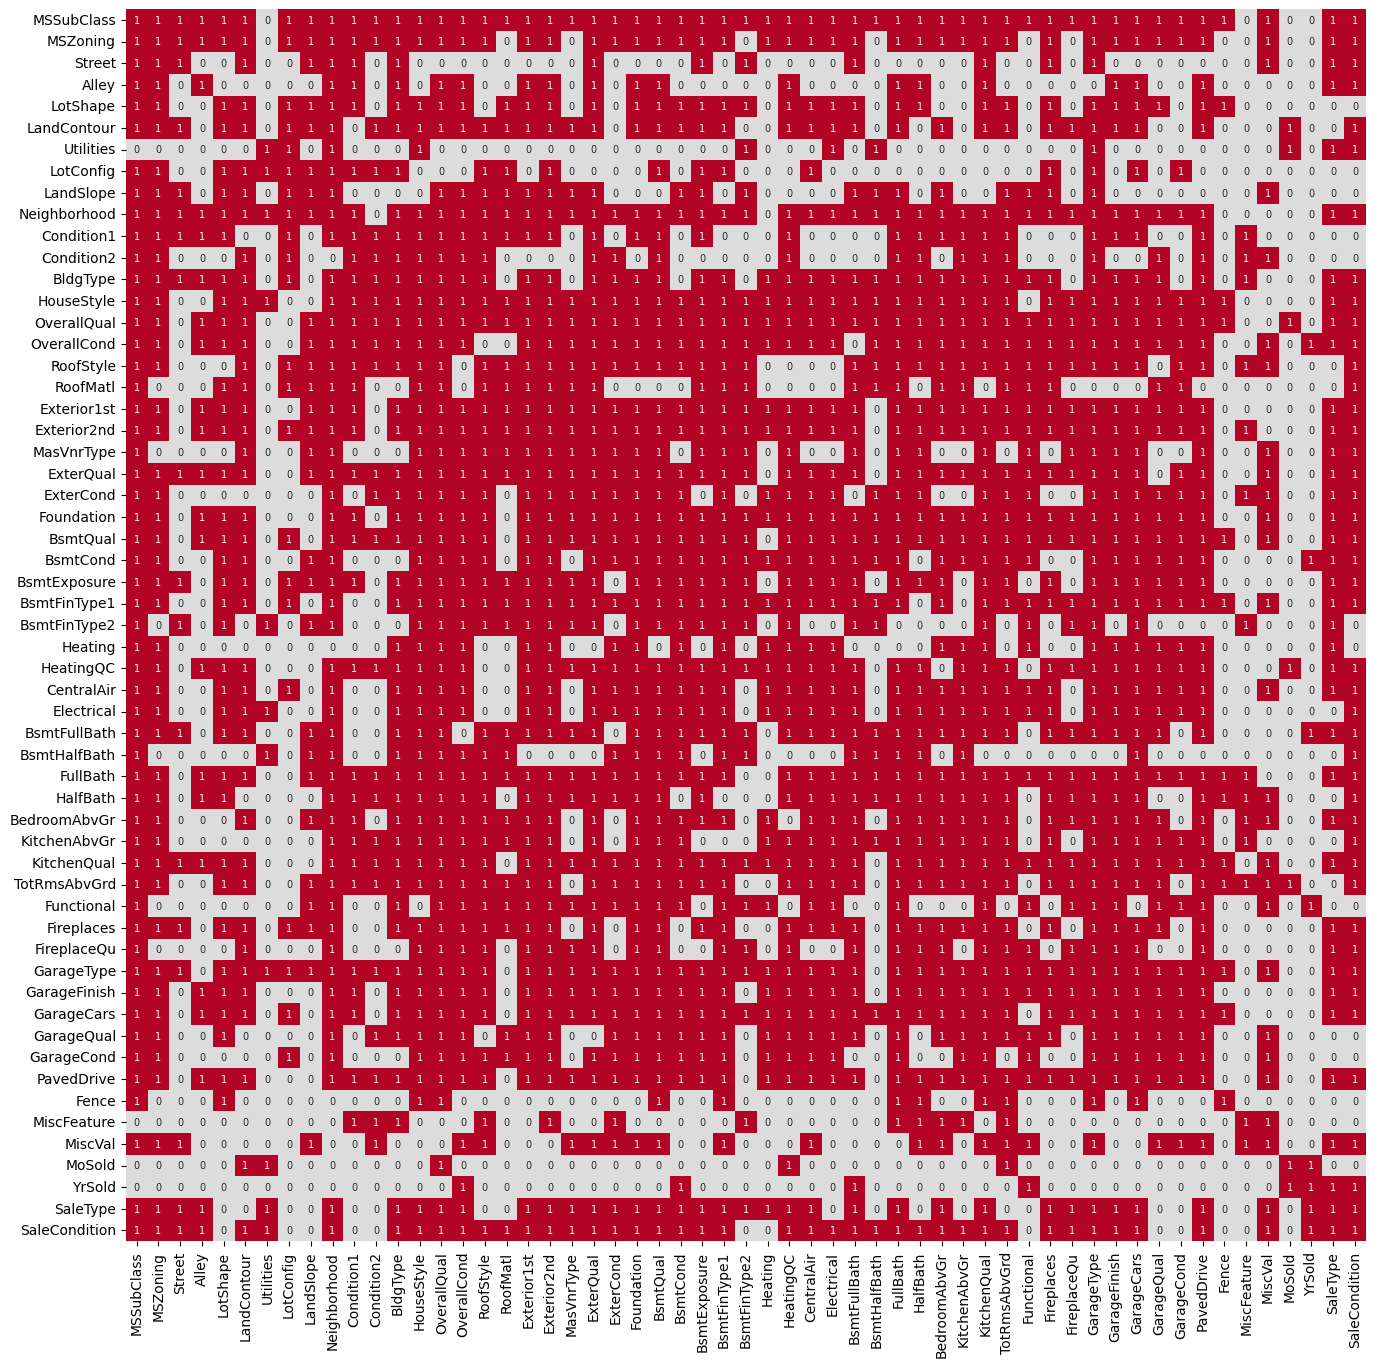

In [23]:
dataframe_chi2_square = dataframe_chi2_square.apply(pd.to_numeric)
plt.figure(figsize=(16,16))
sns.heatmap(dataframe_chi2_square, annot=True, cmap='coolwarm', cbar=False,center=0,annot_kws={"size":7})
plt.show()

## Time for some basic Analysis(Null  Values)

###### Also to notice the Id column has no role to play in the Sales of a House, however we are able to know that all the Ids till 1460 are in Training Set and from 1461 through 2919 constitutes of the Testing Data

###### We have already removed PoolQC as it had 99 percent of null values in both train and tests
###### From here on, Let us seperate the train set in 2 parts (80) columns in the (X) and 1 in y

In [24]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,4,2010,WD,Normal,142125


In [25]:
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,120,0,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,144,0,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,MnPrv,Shed,700,7,2006,WD,Normal


In [26]:
X = train.drop(columns=['SalePrice'])
y = train[['SalePrice']]

In [27]:
train.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [91]:
X

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ThreeSsnPorch,ScreenPorch,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,NaN,0,12,2008,WD,Normal
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,320,0,0,MnPrv,Shed,700,10,2009,WD,Normal
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,8,2007,WD,Normal
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,0,0,NaN,Shed,350,11,2009,WD,Normal
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,4,2008,WD,Abnorml
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,0,0,NaN,NaN,0,1,2008,WD,Normal


In [29]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'FirstFlrSF', 'SecondFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'Paved

In [30]:
pd.set_option('display.max_rows', None)

In [31]:
columns_with_na_train = []
for col in train.columns:
    if train[col].isna().sum() > 0:
        columns_with_na_train.append(col)
        print(f"{col} : {train[col].isna().sum()}")

LotFrontage : 259
Alley : 1369
MasVnrType : 872
MasVnrArea : 8
BsmtQual : 37
BsmtCond : 37
BsmtExposure : 38
BsmtFinType1 : 37
BsmtFinType2 : 38
Electrical : 1
FireplaceQu : 690
GarageType : 81
GarageYrBlt : 81
GarageFinish : 81
GarageQual : 81
GarageCond : 81
Fence : 1179
MiscFeature : 1406


In [32]:
columns_with_na_test = []
for col in test.columns:
    if test[col].isna().sum() > 0:
        columns_with_na_test.append(col)
        print(f"{col} : {test[col].isna().sum()}")

MSZoning : 4
LotFrontage : 227
Alley : 1352
Utilities : 2
Exterior1st : 1
Exterior2nd : 1
MasVnrType : 894
MasVnrArea : 15
BsmtQual : 44
BsmtCond : 45
BsmtExposure : 44
BsmtFinType1 : 42
BsmtFinSF1 : 1
BsmtFinType2 : 42
BsmtFinSF2 : 1
BsmtUnfSF : 1
TotalBsmtSF : 1
BsmtFullBath : 2
BsmtHalfBath : 2
KitchenQual : 1
Functional : 2
FireplaceQu : 730
GarageType : 76
GarageYrBlt : 78
GarageFinish : 78
GarageCars : 1
GarageArea : 1
GarageQual : 78
GarageCond : 78
Fence : 1169
MiscFeature : 1408
SaleType : 1


#### Fence, MiscFeature, Gravel : Columns which are having high number of NA Values, As far as the NA values are considered these are the also one of the categories.

In [33]:
print(len(columns_with_na_train))

18


In [34]:
print(len(columns_with_na_test))

32


In [35]:
[col for col in columns_with_na_train if col not in columns_with_na_test]

['Electrical']

In [36]:
#Columns with na in test - but good in train
[col for col in columns_with_na_test if col not in columns_with_na_train]

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea',
 'SaleType']

In [37]:
columns_with_na_train

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'Fence',
 'MiscFeature']

In [38]:
columns_with_na_train

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'Fence',
 'MiscFeature']

##### Lets first take care of the 'Electrical' Column



In [152]:
train_wo_na = train

In [154]:
train_wo_na = train_wo_na.dropna(subset=['Electrical'])

In [155]:
print(f"train       Shape {train.shape} ")
print(f"train_wo_na Shape {train_wo_na.shape} ")

train       Shape (1460, 80) 
train_wo_na Shape (1459, 80) 


#### Column : MasVnrType: Masonry veneer type - (1 being the most expensive and 5 being the least expensive), as per the values in the comman Analysis done below for the Mean of the Sales Prices is almost same for BrkCmn and Nan Values

   BrkCmn	Brick Common   - 4
   
   BrkFace	Brick Face     - 3 
   
   CBlock	Cinder Block   - 2 
   
   None	None               - 4 
   
   Stone	Stone          - 1 
#### Lets check this with the pivot Table

In [39]:
train['MasVnrType'].fillna('NaN', inplace=True) # as this needs to be done for Getting NaN as one of the values as well!
pd.pivot_table(data=train,index= 'MasVnrType',values = 'SalePrice',dropna=False).sort_values(by = 'SalePrice')

,SalePrice
MasVnrType,
BrkCmn,146318.066667
NaN,156958.243119
BrkFace,204691.871910
Stone,265583.625000


In [ ]:
ordered_categories = ["BrkCmn","NaN","BrkFace","CBlock","Stone"]
ordered_categories = [[col] for col in ordered_categories]
ordinal_MasVnrType = OrdinalEncoder(categories=ordered_categories)
X['MasVnrType1'] = ordinal_MasVnrType.fit_transform(X['MasVnrType']) 